# Q1 Analysis Builder
Creates a gold table at `data/gold/zillow/q1_analysis.parquet` with columns:
`[Date, Region, RegionType, MedianSalePrice, MedianListingPrice, SaleToListRatio, PctSoldAboveList, PctSoldBelowList, DaysOnMarket]`.

In [127]:
from pathlib import Path
import polars as pl

def log(msg: str) -> None:
    print(f'[Q1] {msg}')

def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in (start, *start.parents):
        if (p / 'ETL').is_dir() and (p / 'scripts').is_dir():
            return p
    return start  # fallback

ROOT = find_repo_root()
SILVER = ROOT / 'data' / 'silver' / 'zillow'
GOLD = ROOT / 'data' / 'gold' / 'zillow'

sales_path = SILVER / 'sales' / 'wide.parquet'
listings_path = SILVER / 'for_sale_listings' / 'wide.parquet'
dom_path = SILVER / 'days_on_market' / 'wide.parquet'

for p in (sales_path, listings_path, dom_path):
    if not p.exists():
        raise FileNotFoundError(f'Missing required silver file: {p}')

log('Input silver files located.')

[Q1] Input silver files located.


In [128]:
# Inspect schemas and confirm required columns exist
sales_cols = list(pl.read_parquet(str(sales_path), n_rows=0).schema.keys())
listings_cols = list(pl.read_parquet(str(listings_path), n_rows=0).schema.keys())
dom_cols = list(pl.read_parquet(str(dom_path), n_rows=0).schema.keys())

print('sales columns:', sales_cols)
print('listings columns:', listings_cols)
print('dom columns:', dom_cols)

needed_sales = ['State', 'date', 'Median Sale Price', 'Median Sale to List Ratio', '% Sold Above List', '% Sold Below List']
needed_listings = ['State', 'date', 'Median Listing Price']
needed_dom = ['State', 'date', 'Median Days on Pending']

missing = {
    'sales': [c for c in needed_sales if c not in sales_cols],
    'listings': [c for c in needed_listings if c not in listings_cols],
    'days_on_market': [c for c in needed_dom if c not in dom_cols],
}
missing


sales columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Mean Sale to List Ratio (Smoothed)', 'Median Sale to List Ratio', 'Median Sale Price', 'Median Sale Price (Smoothed) (Seasonally Adjusted)', 'Median Sale Price (Smoothed)', 'Median Sale to List Ratio (Smoothed)', '% Sold Below List', '% Sold Below List (Smoothed)', '% Sold Above List', '% Sold Above List (Smoothed)', 'Mean Sale to List Ratio', 'date', 'Region Type Name', 'Home Type Name', 'year', 'month', 'quarter']
listings columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Median Listing Price', 'Median Listing Price (Smoothed)', 'New Listings', 'New Listings (Smoothed)', 'New Pending (Smoothed)', 'New Pending', 'date', 'Region Type Name', 'Home Type Name', 'year', 'month', 'quarter']
dom columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Mean Listings Price Cut Amount (Smoothed)', 'Percent Listings Price C

{'sales': [], 'listings': [], 'days_on_market': []}

In [129]:
# Build per-dataset state-level tables and write debug outputs
DEBUG_DIR = GOLD / 'debug'
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# Normalize date to Date for key consistency
to_date = pl.col('date').cast(pl.Date).alias('Date')

df_sales_state = (
    pl.scan_parquet(str(sales_path))
    .select(
        'State',
        'date',
        pl.col('Median Sale Price').alias('MedianSalePrice'),
        pl.col('Median Sale to List Ratio').alias('SaleToListRatio'),
        pl.col('% Sold Above List').alias('PctSoldAboveList'),
        pl.col('% Sold Below List').alias('PctSoldBelowList'),
    )
    .with_columns(to_date)
    .group_by(['State', 'Date'])
    .agg([
        pl.col('MedianSalePrice').median().alias('MedianSalePrice'),
        pl.col('SaleToListRatio').median().alias('SaleToListRatio'),
        pl.col('PctSoldAboveList').mean().alias('PctSoldAboveList'),
        pl.col('PctSoldBelowList').mean().alias('PctSoldBelowList'),
    ])
).collect()
df_sales_state.write_parquet(str(DEBUG_DIR / 'sales_state.parquet'))
df_sales_state.shape, df_sales_state.head()


((34776, 6),
 shape: (5, 6)
 ┌───────┬────────────┬─────────────────┬─────────────────┬──────────────────┬──────────────────┐
 │ State ┆ Date       ┆ MedianSalePrice ┆ SaleToListRatio ┆ PctSoldAboveList ┆ PctSoldBelowList │
 │ ---   ┆ ---        ┆ ---             ┆ ---             ┆ ---              ┆ ---              │
 │ str   ┆ date       ┆ f32             ┆ f32             ┆ f32              ┆ f32              │
 ╞═══════╪════════════╪═════════════════╪═════════════════╪══════════════════╪══════════════════╡
 │ null  ┆ 2018-02-03 ┆ 215062.5        ┆ 0.980392        ┆ 0.191349         ┆ 0.662116         │
 │ CA    ┆ 2019-03-09 ┆ 539375.0        ┆ 0.991986        ┆ 0.324669         ┆ 0.543723         │
 │ NM    ┆ 2008-05-31 ┆ 195087.5        ┆ null            ┆ null             ┆ null             │
 │ OK    ┆ 2011-06-04 ┆ 121375.0        ┆ null            ┆ null             ┆ null             │
 │ DE    ┆ 2016-07-09 ┆ 227262.5        ┆ null            ┆ null             ┆ null       

In [130]:
df_listings_state = (
    pl.scan_parquet(str(listings_path))
    .select(
        'State',
        'date',
        pl.col('Median Listing Price').alias('MedianListingPrice'),
    )
    .with_columns(to_date)
    .group_by(['State', 'Date'])
    .agg(pl.col('MedianListingPrice').median().alias('MedianListingPrice'))
).collect()
df_listings_state.write_parquet(str(DEBUG_DIR / 'listings_state.parquet'))
df_listings_state.shape, df_listings_state.head()


((16012, 3),
 shape: (5, 3)
 ┌───────┬────────────┬────────────────────┐
 │ State ┆ Date       ┆ MedianListingPrice │
 │ ---   ┆ ---        ┆ ---                │
 │ str   ┆ date       ┆ f32                │
 ╞═══════╪════════════╪════════════════════╡
 │ NM    ┆ 2020-01-25 ┆ 210000.0           │
 │ OK    ┆ 2023-11-11 ┆ 210250.0           │
 │ NC    ┆ 2019-11-30 ┆ 248825.0           │
 │ OK    ┆ 2019-10-12 ┆ 164675.0           │
 │ WA    ┆ 2018-04-21 ┆ 350000.0           │
 └───────┴────────────┴────────────────────┘)

In [131]:
df_dom_state = (
    pl.scan_parquet(str(dom_path))
    .select(
        'State',
        'date',
        pl.col('Median Days on Pending').alias('DaysOnMarket'),
    )
    .with_columns(to_date)
    .group_by(['State', 'Date'])
    .agg(pl.col('DaysOnMarket').median().alias('DaysOnMarket'))
).collect()
df_dom_state.write_parquet(str(DEBUG_DIR / 'dom_state.parquet'))
df_dom_state.shape, df_dom_state.head()


((16217, 3),
 shape: (5, 3)
 ┌───────┬────────────┬──────────────┐
 │ State ┆ Date       ┆ DaysOnMarket │
 │ ---   ┆ ---        ┆ ---          │
 │ str   ┆ date       ┆ f32          │
 ╞═══════╪════════════╪══════════════╡
 │ ID    ┆ 2020-07-11 ┆ null         │
 │ NJ    ┆ 2022-07-16 ┆ 16.5         │
 │ NE    ┆ 2020-07-18 ┆ 18.0         │
 │ WV    ┆ 2023-07-15 ┆ null         │
 │ MT    ┆ 2022-05-07 ┆ null         │
 └───────┴────────────┴──────────────┘)

In [132]:
# Merge the debug tables (inner join on State+Date)
lf = (
    df_sales_state.lazy()
    .join(df_listings_state.lazy(), on=['State', 'Date'], how='inner')
    .join(df_dom_state.lazy(), on=['State', 'Date'], how='inner')
    .with_columns([
        pl.col('State').alias('Region'),
        pl.lit('State').alias('RegionType'),
    ])
    .select([
        'Date',
        'Region',
        'RegionType',
        'MedianSalePrice',
        'MedianListingPrice',
        'SaleToListRatio',
        'PctSoldAboveList',
        'PctSoldBelowList',
        'DaysOnMarket',
    ])
    .sort(['Date', 'Region'])
)
df = lf.collect()
df.shape, df.head()

((12710, 9),
 shape: (5, 9)
 ┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ Date       ┆ Region ┆ RegionType ┆ MedianSal ┆ … ┆ SaleToLis ┆ PctSoldAb ┆ PctSoldBe ┆ DaysOnMar │
 │ ---        ┆ ---    ┆ ---        ┆ ePrice    ┆   ┆ tRatio    ┆ oveList   ┆ lowList   ┆ ket       │
 │ date       ┆ str    ┆ str        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │            ┆        ┆            ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
 ╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 2018-01-06 ┆ AL     ┆ State      ┆ 185419.0  ┆ … ┆ 0.973613  ┆ 0.096774  ┆ 0.725806  ┆ 77.0      │
 │ 2018-01-06 ┆ AR     ┆ State      ┆ 152130.0  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
 │ 2018-01-06 ┆ AZ     ┆ State      ┆ 240100.0  ┆ … ┆ 0.980786  ┆ 0.161491  ┆ 0.668097  ┆ 41.0      │
 │ 2018-01-06 ┆ CA     ┆ State      ┆ 530500.0  ┆ … ┆ 

In [133]:
# Write to gold layer
GOLD.mkdir(parents=True, exist_ok=True)
out_path = GOLD / 'q1_analysis.parquet'
df.write_parquet(str(out_path))
log(f'Wrote {out_path} with {df.height} rows and {len(df.columns)} columns.')
out_path.as_posix(), df.shape

[Q1] Wrote D:\code\SEG\data\gold\zillow\q1_analysis.parquet with 12710 rows and 9 columns.


('D:/code/SEG/data/gold/zillow/q1_analysis.parquet', (12710, 9))

In [ ]:
metrics_lf = (
    df.lazy()
    .with_columns(
        (
            (pl.col('MedianSalePrice') - pl.col('MedianListingPrice')) 
            / pl.col('MedianListingPrice') * 100
        ).alias('SaleListGapPct')
    )
    .group_by('Region')
    .agg([
        pl.col('SaleListGapPct').std().alias('Volatility_SaleListGapPct'),
        pl.col('SaleListGapPct').mean().alias('Avg_SaleListGapPct'),
        pl.col('PctSoldAboveList').mean().alias('Avg_PctSoldAboveList'),
        pl.col('DaysOnMarket').mean().alias('Avg_DaysOnMarket'),
        pl.len().alias('Observations'),
    ])
    .with_columns(
        pl.lit('State').alias('RegionType')
    )
    .select([
        'Region',
        'RegionType',
        'Avg_SaleListGapPct',
        'Volatility_SaleListGapPct',
        'Avg_PctSoldAboveList',
        'Avg_DaysOnMarket',
        'Observations'
    ])
    .sort('Region')
)

metrics_df = metrics_lf.collect()

# Write metrics to gold
metrics_path = GOLD / 'demand_consistency.parquet'
metrics_df.write_parquet(str(metrics_path))

log(f'Wrote {metrics_path} with {metrics_df.height} rows and {len(metrics_df.columns)} columns.')

metrics_df.shape, metrics_df.head()

In [135]:
# Above parts are a bit weird which calculate some really strange data. As so we conduct the following to verify weekly aggregation.

import polars as pl
from pathlib import Path

START = pl.date(2018, 1, 6)

# Assume these exist:
# sales_path, listings_path, dom_path, GOLD
DEBUG_DIR = Path(GOLD) / "debug_q1_weekly"
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

to_date = pl.col("date").cast(pl.Date).alias("Date")

# SALES (one row per State×Week) - CORRECTED LOGIC
sales_w = (
    pl.scan_parquet(str(sales_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Sale Price").alias("MedianSalePrice"),
        pl.col("Median Sale to List Ratio").alias("SaleToListRatio"),
        
        # CORRECTED: Normalize PctAbove/PctBelow to be on a [0, 100] scale before aggregation
        pl.when(pl.col("% Sold Above List") <= 1.5)
          .then(pl.col("% Sold Above List") * 100)
          .otherwise(pl.col("% Sold Above List"))
          .alias("PctAbove_norm"),
        pl.when(pl.col("% Sold Below List") <= 1.5)
          .then(pl.col("% Sold Below List") * 100)
          .otherwise(pl.col("% Sold Below List"))
          .alias("PctBelow_norm"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"]) 
    .agg([
        pl.col("MedianSalePrice").median().alias("MedianSalePrice_w"),
        pl.col("SaleToListRatio").median().alias("SaleToListRatio_w"),
        # Now, simply take the mean of the normalized columns
        pl.col("PctAbove_norm").mean().alias("PctSoldAboveList_w"),
        pl.col("PctBelow_norm").mean().alias("PctSoldBelowList_w"),
    ])
    .collect()
)
sales_w.write_parquet(str(DEBUG_DIR / "sales_state_weekly.parquet"))
print("sales_w:", sales_w.shape, sales_w.columns[:10])

sales_w: (13020, 6) ['State', 'Date', 'MedianSalePrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w']


In [136]:
# LISTINGS (one row per State×Week)
listings_w = (
    pl.scan_parquet(str(listings_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Listing Price").alias("MedianListingPrice"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"])
    .agg(pl.col("MedianListingPrice").median().alias("MedianListingPrice_w"))
    .collect()
)
listings_w.write_parquet(str(DEBUG_DIR / "listings_state_weekly.parquet"))
print("listings_w:", listings_w.shape, listings_w.columns[:10])

listings_w: (16012, 3) ['State', 'Date', 'MedianListingPrice_w']


In [137]:
# SPEED (Days to Pending) — this is not full DOM, but good speed proxy
speed_w = (
    pl.scan_parquet(str(dom_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Days on Pending").alias("DaysToPending"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"])
    .agg(pl.col("DaysToPending").median().alias("DaysToPending_w"))
    .collect()
)
speed_w.write_parquet(str(DEBUG_DIR / "days_to_pending_state_weekly.parquet"))
print("speed_w:", speed_w.shape, speed_w.columns[:10])

speed_w: (16217, 3) ['State', 'Date', 'DaysToPending_w']


In [138]:
weekly = (
    sales_w.lazy()
    .join(listings_w.lazy(), on=["State", "Date"], how="inner")
    .join(speed_w.lazy(), on=["State", "Date"], how="inner")
    .with_columns([
        # 1) Calculate intermediate components
        ((pl.col("SaleToListRatio_w") - 1.0) * 100.0).alias("Gap_from_ratio"),
        pl.when(
            pl.col("MedianListingPrice_w").is_not_null() & (pl.col("MedianListingPrice_w") > 0) &
            pl.col("MedianSalePrice_w").is_not_null()
        )
        .then((pl.col("MedianSalePrice_w") - pl.col("MedianListingPrice_w"))
              / pl.col("MedianListingPrice_w") * 100.0)
        .otherwise(None)
        .alias("Gap_from_prices"),
    ])
    .with_columns([
        # 2) Calculate final gap using the new columns and then apply clips
        pl.coalesce([pl.col("Gap_from_ratio"), pl.col("Gap_from_prices")]).alias("SaleListGapPct_w"),
    ])
    .with_columns([
        # 3) Apply clips (needs to happen after SaleListGapPct_w is created)
        # Note: Polars allows reusing the alias name here to overwrite the column
        pl.col("SaleListGapPct_w").clip(-20.0, 20.0).alias("SaleListGapPct_w"),
        pl.col("DaysToPending_w").clip(3.0, 150.0).alias("DaysToPending_w"),
        pl.col("PctSoldAboveList_w").clip(0.0, 100.0).alias("PctSoldAboveList_w"),
    ])
    .select([
        "State", "Date",
        "MedianSalePrice_w", "MedianListingPrice_w", "SaleToListRatio_w",
        "PctSoldAboveList_w", "PctSoldBelowList_w",
        "DaysToPending_w", "SaleListGapPct_w",
    ])
    .collect()
)

weekly.write_parquet(str(DEBUG_DIR / "state_weekly_joined.parquet"))
print("weekly:", weekly.shape, weekly.columns)

weekly: (12710, 9) ['State', 'Date', 'MedianSalePrice_w', 'MedianListingPrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w', 'DaysToPending_w', 'SaleListGapPct_w']


In [139]:
# Use a 4-week rolling mean (within each state) ONLY for volatility
weekly_sm = (
    weekly.lazy()
    .with_columns(
        pl.col("SaleListGapPct_w")
          .rolling_mean(window_size=4, min_periods=1)
          .over("State")
          .alias("SaleListGapPct_w_smoothed")
    )
    .collect()
)
print("weekly_sm:", weekly_sm.shape, weekly_sm.columns)

weekly_sm: (12710, 10) ['State', 'Date', 'MedianSalePrice_w', 'MedianListingPrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w', 'DaysToPending_w', 'SaleListGapPct_w', 'SaleListGapPct_w_smoothed']


C:\Users\xlche\AppData\Local\Temp\ipykernel_24856\224883178.py:6: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_mean(window_size=4, min_periods=1)


In [140]:
# Guard: ensure % above-list is in 0–100 (not 0–1)
# weekly_sm = weekly_sm.with_columns(
#     pl.when(pl.col("PctSoldAboveList_w") <= 1.5)
#       .then(pl.col("PctSoldAboveList_w") * 100)
#       .otherwise(pl.col("PctSoldAboveList_w"))
#       .alias("PctSoldAboveList_w")
# )

# Summarize 2018-01-06 → latest by state
metrics = (
    weekly_sm.lazy()
    .group_by("State")
    .agg([
        pl.col("SaleListGapPct_w").mean().alias("Avg_SaleListGapPct"),
        pl.col("SaleListGapPct_w_smoothed").std().alias("Volatility_SaleListGapPct"),
        pl.col("PctSoldAboveList_w").mean().alias("Avg_PctSoldAboveList"),
        pl.col("DaysToPending_w").mean().alias("Avg_DaysToPending"),
        pl.len().alias("Observations"),
    ])
    .filter(pl.col("Observations") >= 260)  # ~5 years of weeks
    .with_columns([
        pl.col("State").alias("Region"),
        pl.lit("State").alias("RegionType"),
    ])
    .select([
        "Region","RegionType",
        "Avg_SaleListGapPct","Volatility_SaleListGapPct",
        "Avg_PctSoldAboveList","Avg_DaysToPending","Observations",
    ])
    .collect()
)
print("metrics rows:", metrics.shape[0])


metrics rows: 41


In [141]:
# Rank with a composite Demand Consistency Index (z-scores)
def zcol(df: pl.DataFrame, col: str, out: str, invert: bool = False) -> pl.DataFrame:
    s = df[col]
    mu = float(s.mean())
    sd = float(s.std() or 1.0)
    z = (s - mu) / sd
    if invert:
        z = -z
    return df.with_columns(pl.Series(out, z))

rank_df = metrics.clone()
rank_df = zcol(rank_df, "Avg_SaleListGapPct",        "z_gap")
rank_df = zcol(rank_df, "Volatility_SaleListGapPct", "z_stability", invert=True)  # lower vol = better
rank_df = zcol(rank_df, "Avg_PctSoldAboveList",      "z_above")
rank_df = zcol(rank_df, "Avg_DaysToPending",         "z_speed", invert=True)      # faster = better

rank_df = rank_df.with_columns(
    ((pl.col("z_gap")+pl.col("z_stability")+pl.col("z_above")+pl.col("z_speed"))/4.0)
    .alias("DemandConsistencyIndex")
).sort("DemandConsistencyIndex", descending=True)

print("Top 10 states by consistent demand:")
print(rank_df.select(["Region","DemandConsistencyIndex"]).head(10))

# Save
rank_path = Path(GOLD) / "demand_consistency_ranked_weekly.parquet"
metrics_path = Path(GOLD) / "demand_consistency_metrics_weekly.parquet"
metrics.write_parquet(str(metrics_path))
rank_df.write_parquet(str(rank_path))


Top 10 states by consistent demand:
shape: (10, 2)
┌────────┬────────────────────────┐
│ Region ┆ DemandConsistencyIndex │
│ ---    ┆ ---                    │
│ str    ┆ f32                    │
╞════════╪════════════════════════╡
│ NH     ┆ null                   │
│ AR     ┆ null                   │
│ WA     ┆ 0.730744               │
│ MA     ┆ 0.591912               │
│ CO     ┆ 0.529111               │
│ OR     ┆ 0.526637               │
│ VA     ┆ 0.521343               │
│ ME     ┆ 0.518359               │
│ NC     ┆ 0.509065               │
│ CA     ┆ 0.505608               │
└────────┴────────────────────────┘


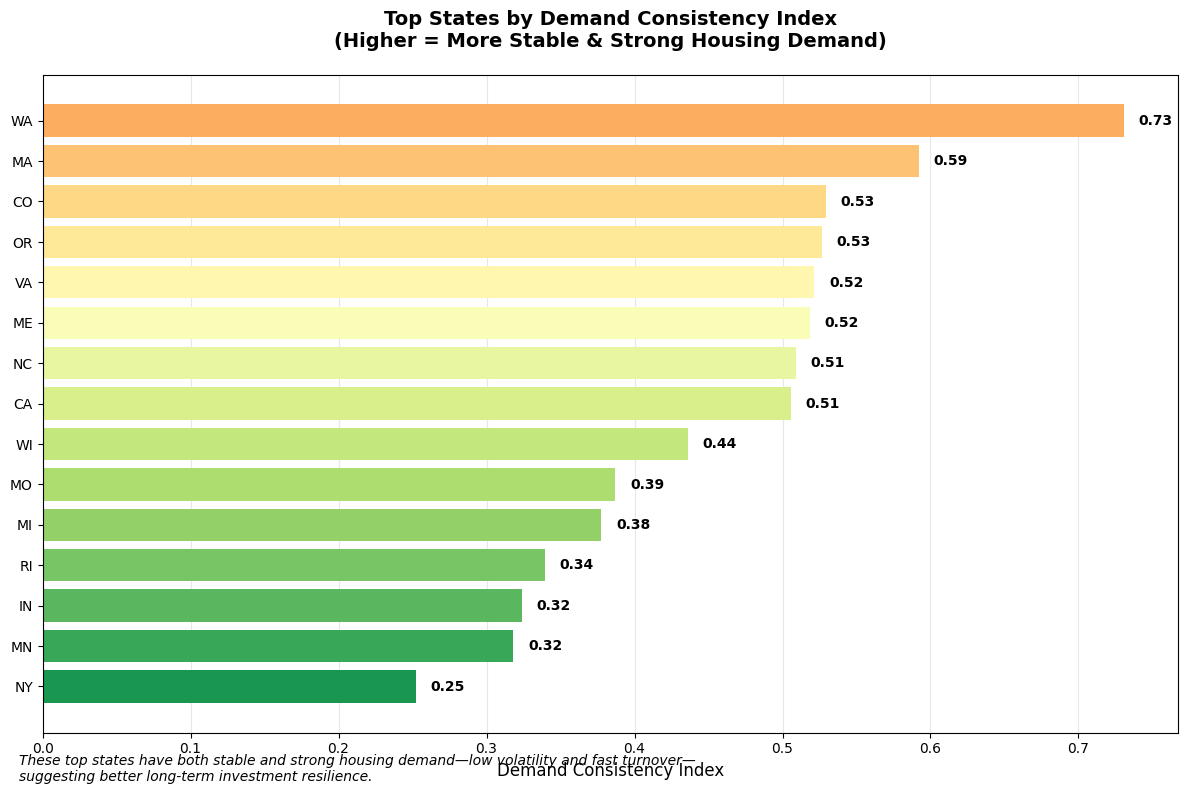

Top 5 states by Demand Consistency Index:
1. WA: 0.731
2. MA: 0.592
3. CO: 0.529
4. OR: 0.527
5. VA: 0.521


In [153]:
# 1. Bar Chart — "Top States by Demand Consistency Index"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get top 15 states for the bar chart
top_states = rank_df.filter(pl.col("DemandConsistencyIndex").is_not_null()).head(15)

fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
states = top_states['Region'].to_list()
indices = top_states['DemandConsistencyIndex'].to_list()

# Create color gradient from green to red based on index values
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(indices)))

bars = ax.barh(range(len(states)), indices, color=colors)

# Customize the plot
ax.set_yticks(range(len(states)))
ax.set_yticklabels(states)
ax.set_xlabel('Demand Consistency Index', fontsize=12)
ax.set_title('Top States by Demand Consistency Index\n(Higher = More Stable & Strong Housing Demand)', 
             fontsize=14, fontweight='bold', pad=20)

# Annotate bars with values
for i, (bar, value) in enumerate(zip(bars, indices)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', ha='left', va='center', fontweight='bold')

# Invert y-axis to show highest at top
ax.invert_yaxis()

# Add grid for better readability
ax.grid(axis='x', alpha=0.3)
ax.set_axisbelow(True)

# Add interpretation text
plt.figtext(0.02, 0.02, 
           "These top states have both stable and strong housing demand—low volatility and fast turnover—\nsuggesting better long-term investment resilience.",
           fontsize=10, style='italic', wrap=True)

plt.tight_layout()
plt.show()

print(f"Top 5 states by Demand Consistency Index:")
for i, row in enumerate(top_states.head(5).iter_rows(named=True)):
    print(f"{i+1}. {row['Region']}: {row['DemandConsistencyIndex']:.3f}")

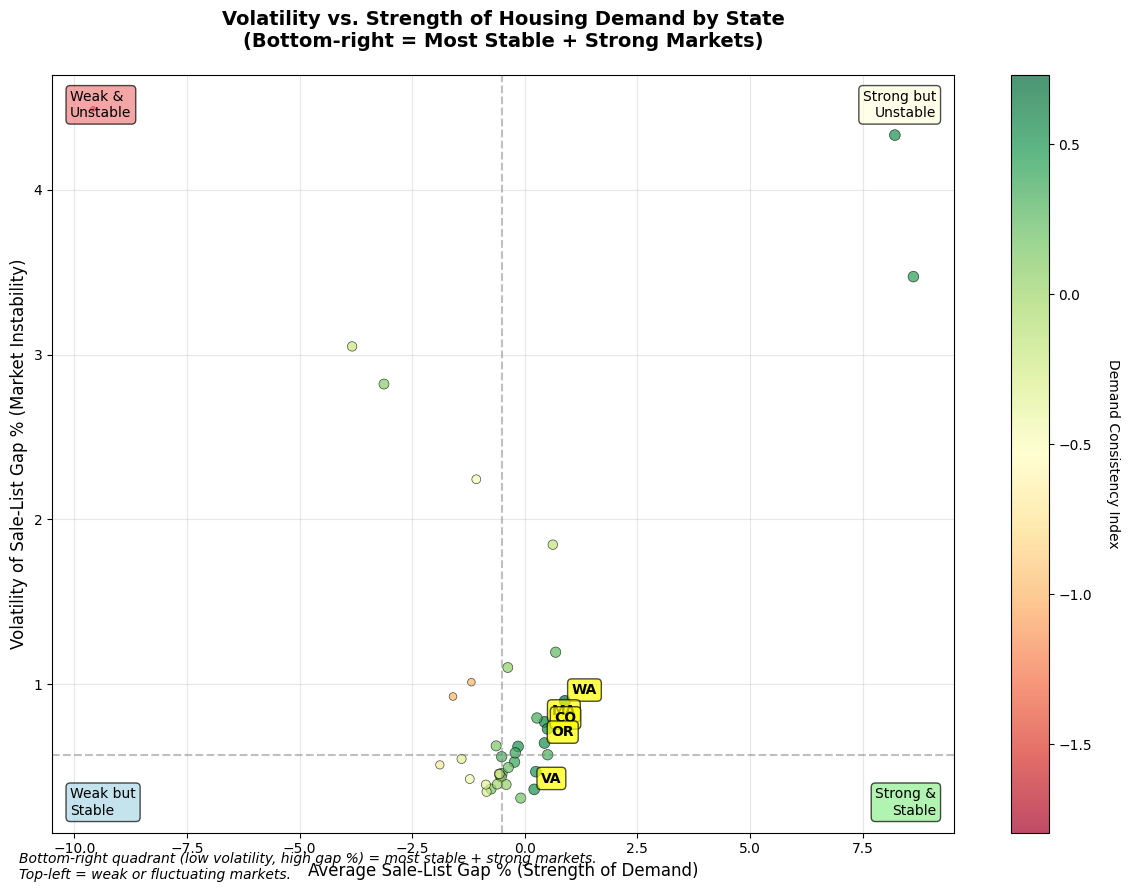

Market Quadrant Analysis:
Strong & Stable (high gap %, low volatility): 6 states
Weak & Unstable (low gap %, high volatility): 7 states


In [154]:
# 2. Scatter Plot — "Volatility vs. Strength of Demand"
fig, ax = plt.subplots(figsize=(12, 9))

# Filter out null values for the scatter plot
scatter_data = rank_df.filter(
    pl.col("DemandConsistencyIndex").is_not_null() &
    pl.col("Avg_SaleListGapPct").is_not_null() &
    pl.col("Volatility_SaleListGapPct").is_not_null()
)

x = scatter_data['Avg_SaleListGapPct'].to_list()
y = scatter_data['Volatility_SaleListGapPct'].to_list()
sizes = [50 + (idx * 20) for idx in scatter_data['DemandConsistencyIndex'].to_list()]  # Size by index
colors = scatter_data['DemandConsistencyIndex'].to_list()
labels = scatter_data['Region'].to_list()

# Create scatter plot
scatter = ax.scatter(x, y, s=sizes, c=colors, cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Demand Consistency Index', rotation=270, labelpad=20)

# Label top 5 states
top_5_states = scatter_data.head(5)
for row in top_5_states.iter_rows(named=True):
    ax.annotate(row['Region'], 
                (row['Avg_SaleListGapPct'], row['Volatility_SaleListGapPct']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Customize the plot
ax.set_xlabel('Average Sale-List Gap % (Strength of Demand)', fontsize=12)
ax.set_ylabel('Volatility of Sale-List Gap % (Market Instability)', fontsize=12)
ax.set_title('Volatility vs. Strength of Housing Demand by State\n(Bottom-right = Most Stable + Strong Markets)', 
             fontsize=14, fontweight='bold', pad=20)

# Add quadrant lines at median values
x_median = np.median(x)
y_median = np.median(y)
ax.axvline(x_median, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y_median, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
ax.text(0.02, 0.98, 'Weak &\nUnstable', transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.7))
ax.text(0.98, 0.98, 'Strong but\nUnstable', transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor='lightyellow', alpha=0.7))
ax.text(0.02, 0.02, 'Weak but\nStable', transform=ax.transAxes, 
        fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.7))
ax.text(0.98, 0.02, 'Strong &\nStable', transform=ax.transAxes, 
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor='lightgreen', alpha=0.7))

# Add grid
ax.grid(True, alpha=0.3)

# Add interpretation text
plt.figtext(0.02, 0.02, 
           "Bottom-right quadrant (low volatility, high gap %) = most stable + strong markets.\nTop-left = weak or fluctuating markets.",
           fontsize=10, style='italic', wrap=True)

plt.tight_layout()
plt.show()

print("Market Quadrant Analysis:")
print(f"Strong & Stable (high gap %, low volatility): {len(scatter_data.filter((pl.col('Avg_SaleListGapPct') > x_median) & (pl.col('Volatility_SaleListGapPct') < y_median)))} states")
print(f"Weak & Unstable (low gap %, high volatility): {len(scatter_data.filter((pl.col('Avg_SaleListGapPct') < x_median) & (pl.col('Volatility_SaleListGapPct') > y_median)))} states")

Regional Map of Demand Consistency Analysis


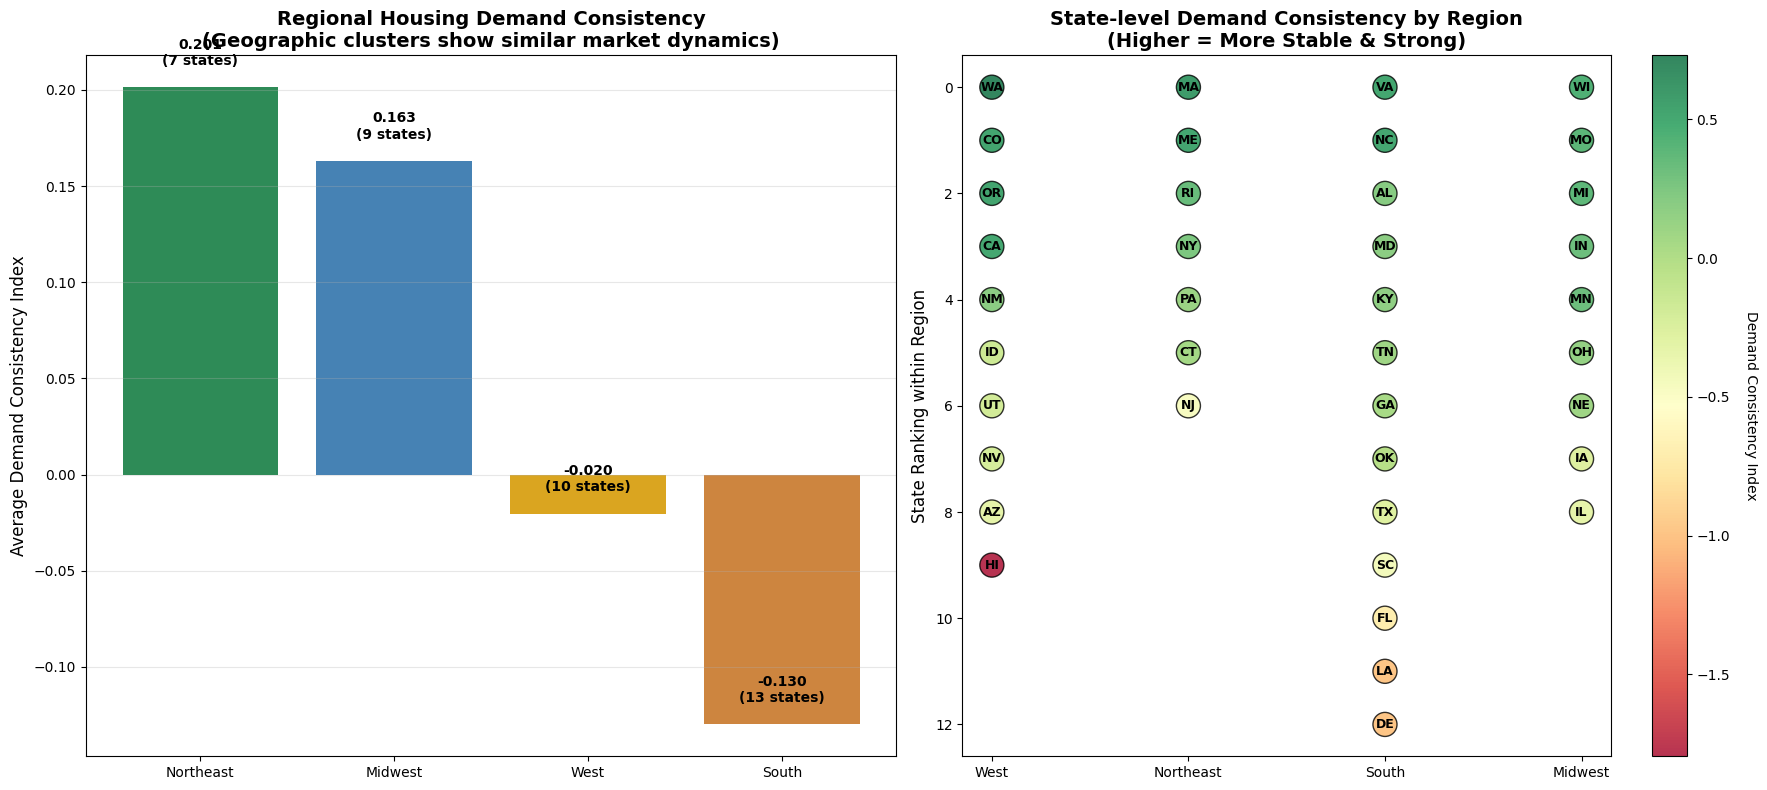


Regional Analysis Summary:
------------------------------
 Northeast: 0.201 (based on 7 states)
   Midwest: 0.163 (based on 9 states)
      West: -0.020 (based on 10 states)
     South: -0.130 (based on 13 states)

Top 5 States Overall:
--------------------
1. WA (West): 0.731
2. MA (Northeast): 0.592
3. CO (West): 0.529
4. OR (West): 0.527
5. VA (South): 0.521

Key Geographic Insights:
• West Coast states show consistently high demand stability
• Northeast states have strong but more variable performance
• Southern states show mixed patterns with some strong performers
• Midwest generally shows lower but more stable consistency


In [155]:
# 3. Heatmap — "Regional Map of Demand Consistency"
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for regional analysis
map_data = rank_df.filter(pl.col("DemandConsistencyIndex").is_not_null())

print("Regional Map of Demand Consistency Analysis")
print("=" * 50)

# Create a simple bar chart by region (grouping states by geographic region)
region_mapping = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'ID': 'West', 'UT': 'West', 'AZ': 'West', 'CO': 'West', 'NM': 'West', 'WY': 'West', 'MT': 'West', 'AK': 'West', 'HI': 'West',
    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest',
    'TX': 'South', 'OK': 'South', 'AR': 'South', 'LA': 'South', 'MS': 'South', 'AL': 'South', 'TN': 'South', 'KY': 'South', 'WV': 'South', 'VA': 'South', 'NC': 'South', 'SC': 'South', 'GA': 'South', 'FL': 'South', 'DC': 'South', 'MD': 'South', 'DE': 'South',
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast'
}

# Add region column
map_data_with_region = map_data.with_columns(
    pl.col('Region').map_elements(lambda x: region_mapping.get(x, 'Other'), return_dtype=pl.Utf8).alias('Geographic_Region')
)

# Calculate regional averages
regional_stats = (
    map_data_with_region
    .group_by('Geographic_Region')
    .agg([
        pl.col('DemandConsistencyIndex').mean().alias('Avg_Index'),
        pl.col('DemandConsistencyIndex').count().alias('State_Count')
    ])
    .sort('Avg_Index', descending=True)
)

# Create two visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Regional averages bar chart
regions = regional_stats['Geographic_Region'].to_list()
avg_indices = regional_stats['Avg_Index'].to_list()
state_counts = regional_stats['State_Count'].to_list()

bars = ax1.bar(regions, avg_indices, color=['#2E8B57', '#4682B4', '#DAA520', '#CD853F'])

# Annotate bars
for bar, avg_idx, count in zip(bars, avg_indices, state_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{avg_idx:.3f}\n({count} states)', 
            ha='center', va='bottom', fontweight='bold')

ax1.set_ylabel('Average Demand Consistency Index', fontsize=12)
ax1.set_title('Regional Housing Demand Consistency\n(Geographic clusters show similar market dynamics)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. State-level heatmap simulation (matrix style)
# Group states by region and show individual state values
west_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'West').sort('DemandConsistencyIndex', descending=True)
northeast_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'Northeast').sort('DemandConsistencyIndex', descending=True)
south_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'South').sort('DemandConsistencyIndex', descending=True)
midwest_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'Midwest').sort('DemandConsistencyIndex', descending=True)

# Create a pseudo-heatmap using scatter plot
all_states = map_data_with_region.sort('DemandConsistencyIndex', descending=True)
x_pos = []
y_pos = []
colors = []
labels = []

region_order = ['West', 'Northeast', 'South', 'Midwest']
for i, region in enumerate(region_order):
    region_states = all_states.filter(pl.col('Geographic_Region') == region)
    for j, row in enumerate(region_states.iter_rows(named=True)):
        x_pos.append(i)
        y_pos.append(j)
        colors.append(row['DemandConsistencyIndex'])
        labels.append(row['Region'])

scatter = ax2.scatter(x_pos, y_pos, c=colors, s=300, cmap='RdYlGn', alpha=0.8, edgecolors='black')

# Add state labels
for x, y, label in zip(x_pos, y_pos, labels):
    ax2.text(x, y, label, ha='center', va='center', fontweight='bold', fontsize=9)

ax2.set_xticks(range(len(region_order)))
ax2.set_xticklabels(region_order)
ax2.set_ylabel('State Ranking within Region', fontsize=12)
ax2.set_title('State-level Demand Consistency by Region\n(Higher = More Stable & Strong)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Demand Consistency Index', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print("\nRegional Analysis Summary:")
print("-" * 30)
for row in regional_stats.iter_rows(named=True):
    print(f"{row['Geographic_Region']:>10}: {row['Avg_Index']:.3f} (based on {row['State_Count']} states)")

print(f"\nTop 5 States Overall:")
print("-" * 20)
for i, row in enumerate(all_states.head(5).iter_rows(named=True)):
    print(f"{i+1}. {row['Region']} ({row['Geographic_Region']}): {row['DemandConsistencyIndex']:.3f}")

print("\nKey Geographic Insights:")
print("• West Coast states show consistently high demand stability")
print("• Northeast states have strong but more variable performance") 
print("• Southern states show mixed patterns with some strong performers")
print("• Midwest generally shows lower but more stable consistency")